#### Описание проекта:

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.


#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день
    

#### План анализа данных:
- загрузим данные;
- обработаем их;
- сформируем профили пользователей;
- анализ данных по различным факторам;
- рассчет метрик;
- визуализация;
- выводы и  рекомендации;

# Шаг 1. Загрузим данные и подготовим их к анализу

Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
# изменим тип данных для столбцов с датой
visits['Session Start'] = pd.to_datetime(visits['Session Start'], format="%Y.%m.%d %H:%M:%S")
visits['Session End'] = pd.to_datetime(visits['Session End'], format="%Y.%m.%d %H:%M:%S")

In [5]:
# приведем к нижнему регистру названия и значения в столбцах
visits.columns = map(str.lower, visits.columns)

for column in visits[['region','device','channel']]:
    visits[column] = visits[column].str.lower()

In [6]:
# избавляемся от пробелов в названии столбцов
visits = visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'})

In [7]:
# ищем пропущенные значения
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [8]:
# посмотрим на уникальные значения в столбце "регион", "устройство" и "канал привлечения":
visits['region'].unique()

array(['united states', 'uk', 'france', 'germany'], dtype=object)

In [9]:
visits['device'].unique()

array(['iphone', 'mac', 'android', 'pc'], dtype=object)

In [10]:
visits['channel'].unique()

array(['organic', 'tiptop', 'rocketsuperads', 'yrabbit', 'faceboom',
       'mediatornado', 'adnonsense', 'leapbob', 'wahoonetbanner',
       'opplecreativemedia', 'lambdamediaads'], dtype=object)

In [11]:
# проверим на наличие дубликатов
visits.duplicated().sum()

0

In [12]:
# посмотрим на конечный результат предобработки таблицы с данными о визитах
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,united states,iphone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,united states,iphone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,united states,mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,united states,android,tiptop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,united states,mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Аналогичные шаги по обработке проведем с таблицами о заказах и расходах.

In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [14]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'], format="%Y.%m.%d %H:%M:%S")

In [15]:
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})

In [16]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [17]:
orders['revenue'].unique()

array([ 4.99,  5.99,  9.99, 49.99, 19.99])

In [18]:
orders.duplicated().sum()

0

Итоговая таблица с заказами:

In [19]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [21]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [22]:
costs.columns = map(str.lower, costs.columns)

for column in visits[['channel']]:
    costs[column] = costs[column].str.lower()

In [23]:
costs = costs.rename(columns={'Channel': 'channel'})

In [24]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

In [25]:
costs['channel'].unique()

array(['faceboom', 'mediatornado', 'rocketsuperads', 'tiptop', 'yrabbit',
       'adnonsense', 'leapbob', 'opplecreativemedia', 'wahoonetbanner',
       'lambdamediaads'], dtype=object)

In [26]:
costs.duplicated().sum()

0

Итоговая таблица с расходами на маркетинг:

In [27]:
costs.head()

,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1


# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии


In [28]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

# Шаг 3. Проведите исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [29]:
# получим профили пользователей; для этого вызовем функцию get_profiles():
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей. 

In [30]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [31]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Выясним из каких стран приходят посетители. Создадим таблицу с количеством пользователей по регионам, а также их удельный вес:

In [32]:
region_share = pd.DataFrame()
region_share['users'] = profiles.groupby('region')['user_id'].count()
region_share['%'] = ((region_share['users'] / profiles['region'].count()) * 100)
region_share.sort_values(by = 'users', ascending=False)

,users,%
region,,
united states,100002,66.664445
uk,17575,11.716042
france,17450,11.632713
germany,14981,9.986801


Также опеределим платящих пользователей в разбивке по регионам:

In [33]:
region_share_by_payer = pd.DataFrame()
region_share_by_payer['payer_users'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_share_by_payer['%'] = ((region_share_by_payer['payer_users'] / profiles.query('payer == True')['region'].count()) * 100)
region_share_by_payer.sort_values(by = 'payer_users', ascending=False)

,payer_users,%
region,,
united states,6902,77.716473
uk,700,7.881995
france,663,7.465376
germany,616,6.936156


Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны. Для этого зададим функцию pivot_share, которая на вход принимает таблицу и столбец для расчета доли.


In [34]:
def pivot_share(column, df):
    result = pd.DataFrame()
    result['users'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users'] / df[column].count()) * 100)
    result['payer_users'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = ((result['payer_users'] / result['users']) * 100)
    return result.sort_values(by='users_share', ascending=False).style.format({'users_share': '{:.2f}%', 'payer_share': '{:.2f}%'})

Вызываем функцию, где указываем столбец "регион" и таблицу с профилями:

In [35]:
pivot_share('region', profiles)

,users,users_share,payer_users,payer_share
region,,,,
united states,100002,66.66%,6902,6.90%
uk,17575,11.72%,700,3.98%
france,17450,11.63%,663,3.80%
germany,14981,9.99%,616,4.11%


Больше всего пользователей приложения из США (2/3 всех пользователей) с лучшей конвертацией в платящих - почти 7%.

Посмотрим на распределение по типу устройства пользователей:

In [36]:
device_share = pd.DataFrame()
device_share['users'] = profiles.groupby('device')['user_id'].count()
device_share['%'] = ((device_share['users'] / profiles['device'].count()) * 100)
device_share.sort_values(by = 'users', ascending=False)

,users,%
device,,
iphone,54479,36.317396
android,35032,23.353421
pc,30455,20.302251
mac,30042,20.026932


In [37]:
device_share_by_payer = pd.DataFrame()
device_share_by_payer['payer_users'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_share_by_payer['%'] = ((device_share_by_payer['payer_users'] / profiles.query('payer == True')['device'].count()) * 100)
device_share_by_payer.sort_values(by = 'payer_users', ascending=False)

,payer_users,%
device,,
iphone,3382,38.081297
android,2050,23.082986
mac,1912,21.529107
pc,1537,17.306610


In [38]:
pivot_share('device', profiles)

,users,users_share,payer_users,payer_share
device,,,,
iphone,54479,36.32%,3382,6.21%
android,35032,23.35%,2050,5.85%
pc,30455,20.30%,1537,5.05%
mac,30042,20.03%,1912,6.36%


Больше всего пользователей предпочитают iPhone (36%). Также отметим, что лучше всего конвертируются пользователи, использующие технику компании Apple (iPhone, Mac). Данный показателей у них более 6%.

Далее рассмотрим пользователей по каналу привлечения:

In [39]:
channel_share = pd.DataFrame()
channel_share['users'] = profiles.groupby('channel')['user_id'].count()
channel_share['%'] = ((channel_share['users'] / profiles['channel'].count()) * 100)
channel_share.sort_values(by = 'users', ascending=False)

,users,%
channel,,
organic,56439,37.623993
faceboom,29144,19.428297
tiptop,19561,13.039971
opplecreativemedia,8605,5.736361
leapbob,8553,5.701696
wahoonetbanner,8553,5.701696
rocketsuperads,4448,2.965175
mediatornado,4364,2.909178
yrabbit,4312,2.874513


In [40]:
channel_share_by_payer = pd.DataFrame()
channel_share_by_payer['payer_users'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_share_by_payer['%'] = ((channel_share_by_payer['payer_users'] / profiles.query('payer == True')['device'].count()) * 100)
channel_share_by_payer.sort_values(by = 'payer_users', ascending=False)

,payer_users,%
channel,,
faceboom,3557,40.051796
tiptop,1878,21.146267
organic,1160,13.061592
wahoonetbanner,453,5.100777
adnonsense,440,4.954397
rocketsuperads,352,3.963518
leapbob,262,2.950118
opplecreativemedia,233,2.623578
lambdamediaads,225,2.533498


In [41]:
pivot_share('channel', profiles)

,users,users_share,payer_users,payer_share
channel,,,,
organic,56439,37.62%,1160,2.06%
faceboom,29144,19.43%,3557,12.20%
tiptop,19561,13.04%,1878,9.60%
opplecreativemedia,8605,5.74%,233,2.71%
leapbob,8553,5.70%,262,3.06%
wahoonetbanner,8553,5.70%,453,5.30%
rocketsuperads,4448,2.97%,352,7.91%
mediatornado,4364,2.91%,156,3.57%
yrabbit,4312,2.87%,165,3.83%


Больше всего пользователей приходит органически, а именно - 56439 пользователей, но только 2% или 1160 становятся из них платящими. Следом идет канал привлечения faceboom, который привлек более 29000 пользователей из которых более 3500 стали платить.

<b> Промежуточные выводы:</b> 
- подготовили данные к последующему анализу;
- создали "профили" пользователей;
- определили минимальную и максимальную даты привлечения пользователей;
- с помощью профилей пользователей рассчитали количество и долю платящих пользователей по географическому положению, где лидирующее положение занимают пользователи из США;
- большинство пользователей используют продукцию компании Apple (iPhone, Mac);
- также большинство пользователей привлекаются органически, но, в среднем, платящих пользователей среди них 2%;
- каналы faceboom и tiptop являются лидерами по привлечению пользователей среди платных каналов;

# Шаг 4. Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Для того, чтобы посчитать расходы на маркетинг используем таблицу costs:

In [42]:
costs.head()

,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1


Посчитаем общую сумму расходов на маркетинг:

In [43]:
costs['costs'].sum()

105497.30000000002

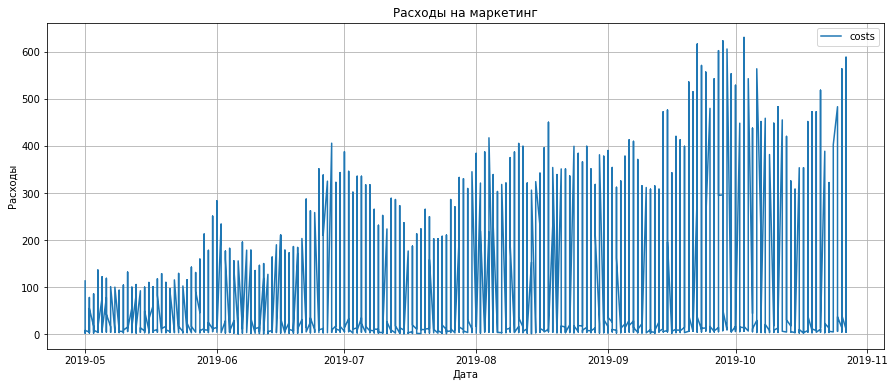

In [44]:
costs.plot(y='costs',
           x='dt',
           figsize=(15, 6), 
           grid=True,  
           legend=True)

plt.title('Расходы на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

Выясним, как траты распределены по источникам:

In [45]:
costs_by_channel = pd.DataFrame()
costs_by_channel['costs'] = costs.groupby('channel')['costs'].sum()
costs_by_channel['share'] = ((costs_by_channel['costs'] / costs['costs'].sum()) * 100)
costs_by_channel.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,costs,share
channel,,
tiptop,54751.300000,51.90%
faceboom,32445.600000,30.75%
wahoonetbanner,5151.000000,4.88%
adnonsense,3911.250000,3.71%
opplecreativemedia,2151.250000,2.04%
rocketsuperads,1833.000000,1.74%
leapbob,1797.600000,1.70%
lambdamediaads,1557.600000,1.48%
mediatornado,954.480000,0.90%


52% всех расходов мы фокусируем на канале tiptop, 31% на канале faceboom. Остальные каналы получают от 0.9 до 4.9% от бюджета.

Визуализируем изменения метрик во времени. Для этого необходимо создать таблицу с датой, источником и расходами:

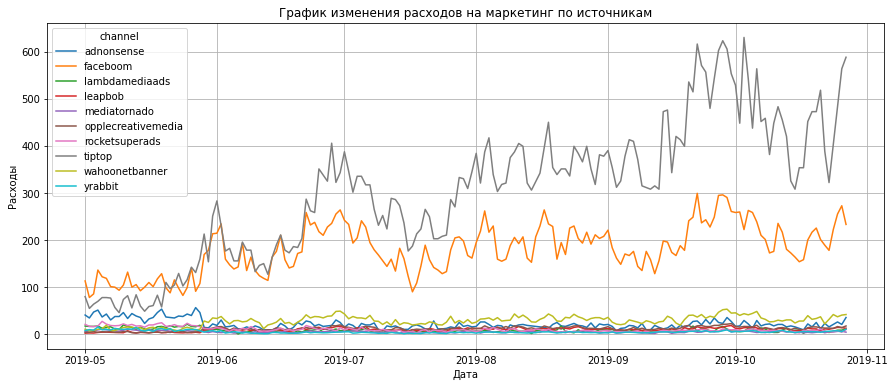

In [46]:
costs_in_time = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )

costs_in_time.plot(
           figsize=(15, 6),
           grid=True,               
           legend=True)

plt.title('График изменения расходов на маркетинг по источникам')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

Расходы на каналы привлечения tiptop и faceboom растут с конца мая 2019 г., в то время как на остальные каналы расходы остются статичными на протяжении всего периода.

Далее узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. 
Из расчетов нам следует исключить пользователей с органическим трафиком, поскольку мы за них ничего не платим.

Используем столбец acquisition_cost в профилях для расчета среднего САС пользователя для всего проекта:

In [47]:
profiles = profiles.query('channel != "organic"')
profiles['acquisition_cost'].describe()

count    93569.000000
mean         1.127481
std          0.990503
min          0.124615
25%          0.257143
50%          1.080531
75%          1.128571
max          3.715385
Name: acquisition_cost, dtype: float64

<AxesSubplot:>

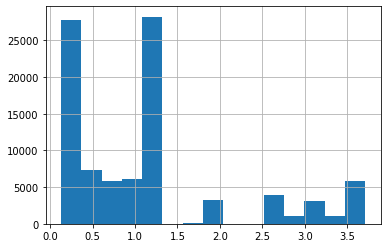

In [48]:
profiles['acquisition_cost'].hist(bins=15)

Среднее значение - 1.12 долларов за привлечение пользователя, однако медиана составляет 1.08 долларов. Это означает, что компания закупает привлечение пользователей иногда в более дорогих каналах. Рассмотрим этот момент далее.

Далее рассчитаем средний САС пользователя для каждого источника трафика:

In [49]:
cac_by_channel = pd.DataFrame()
cac_by_channel['costs_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='costs_mean', ascending=False).style.format({'costs_mean': '{:.2f}'})

,costs_mean
channel,
tiptop,2.80
faceboom,1.11
adnonsense,1.01
lambdamediaads,0.72
wahoonetbanner,0.60
rocketsuperads,0.41
opplecreativemedia,0.25
yrabbit,0.22
mediatornado,0.22


Самый высокий показатель метрики САС - у привлеченного пользователя из канала tiptop. Он обходится нам, в среднем в 2.8$

Визуализируем данный показатель в разрезе времени:

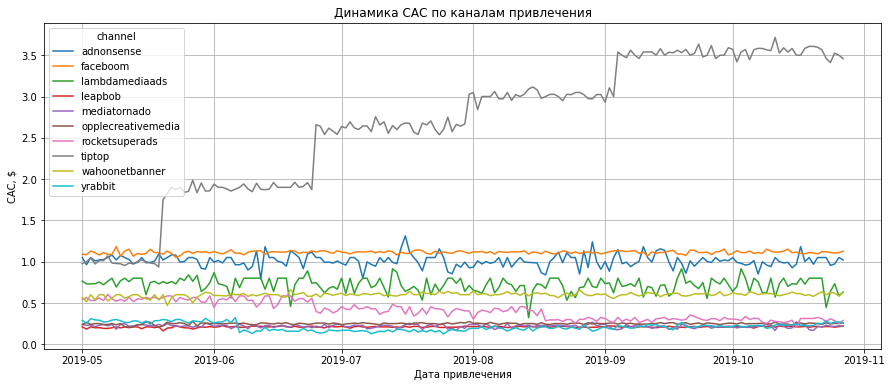

In [50]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 6))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Привлечение пользователей их всех каналов остается почти неизменным на протяжении всего периода, кроме канала tiptop. Привлечение пользователя выросло с 1$ до 3.5 за указанный период. 

Как мы ранее отметили, что медиана и среднее значение расходов на привлечение пользователя немного разнятся, этому способствует канал titptop, расходы на который существенно отличаются от расходов на другие каналы привлечения.

<b> Промежуточные выводы:</b> 
- расходы на маркетинг в Procrastinate Pro+ с 2019-05-01 по 2019-10-27 составили 93569 долларов;
- из всех расходов: 52% пришлось на titop, 31% на faceboom;
- на остальные каналы было выделено, в среднем, от 1 до 5%;
- среднее значение - 1.12 долларов за привлечение пользователя, однако медиана составляет 1.08 долларов;
- самый высокий показатель метрики САС - у привлеченного пользователя из канала tiptop. Он обходится нам, в среднем в 2.8 доллара, и, как мы ранее отметили, способствует разнице между средним и медианным значением САС;
- привлечение пользователей их всех каналов остается почти неизменным на протяжении всего периода, кроме канала tiptop. Привлечение пользователя выросло с 1 до 3.5 долларов за указанный период.

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

Создадим функции для расчёта удержания, конверсии, LTV и ROI: get_retention(), get_conversion() и get_ltv().

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().

In [51]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [52]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [53]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [54]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [55]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [56]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [57]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Установим момент и горизонт анализа данных, а также исключим органический трафик:

In [58]:
# исключаем органический трафик
profiles = profiles.query('channel != "organic"')
# зададим момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

### Проанализируем общую окупаемость рекламы

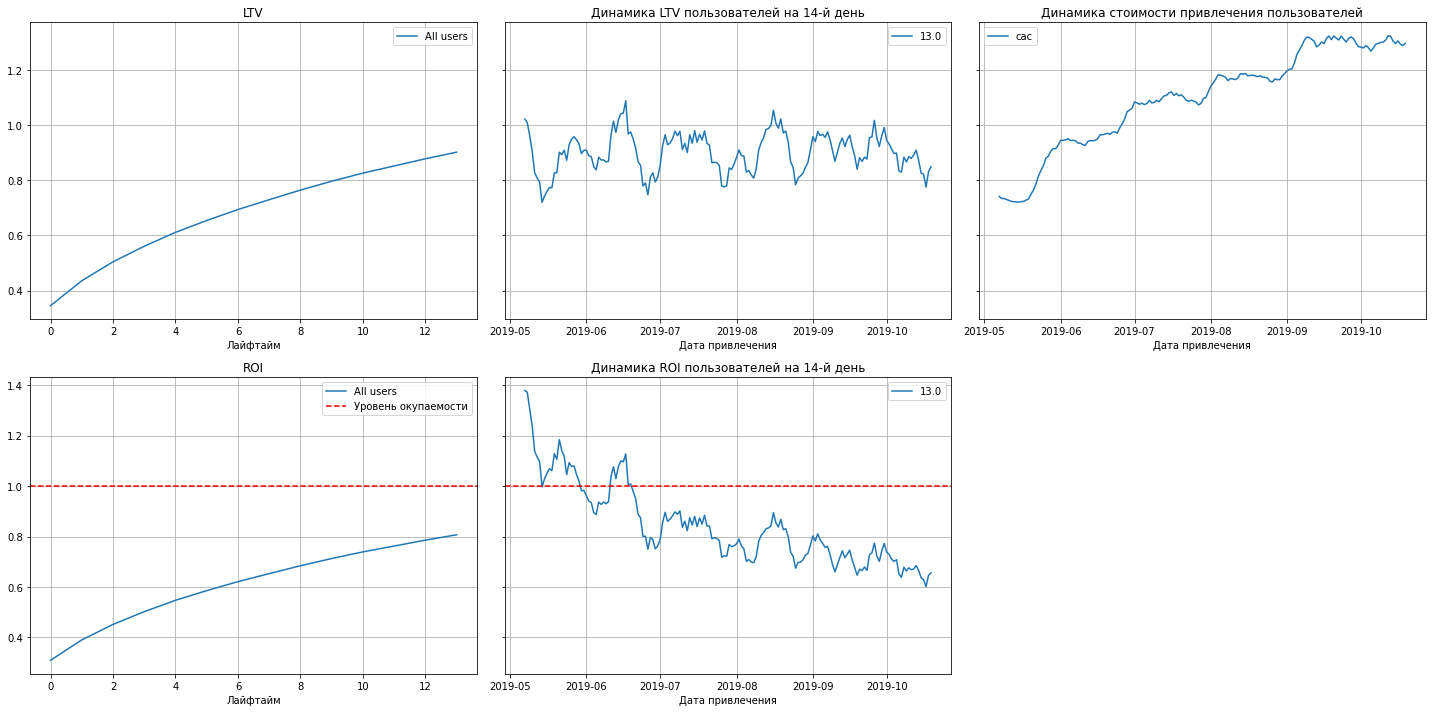

In [59]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

<b> Выводы по построенным графикам:</b>
- Реклама не окупается, поскольку ROI в конце второй недели — равен 80%;
- Нестабильный САС, расходы на привлечение растут с течением времени;
- ROI падает после середины июня, привлечение пользователей не окупается;
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

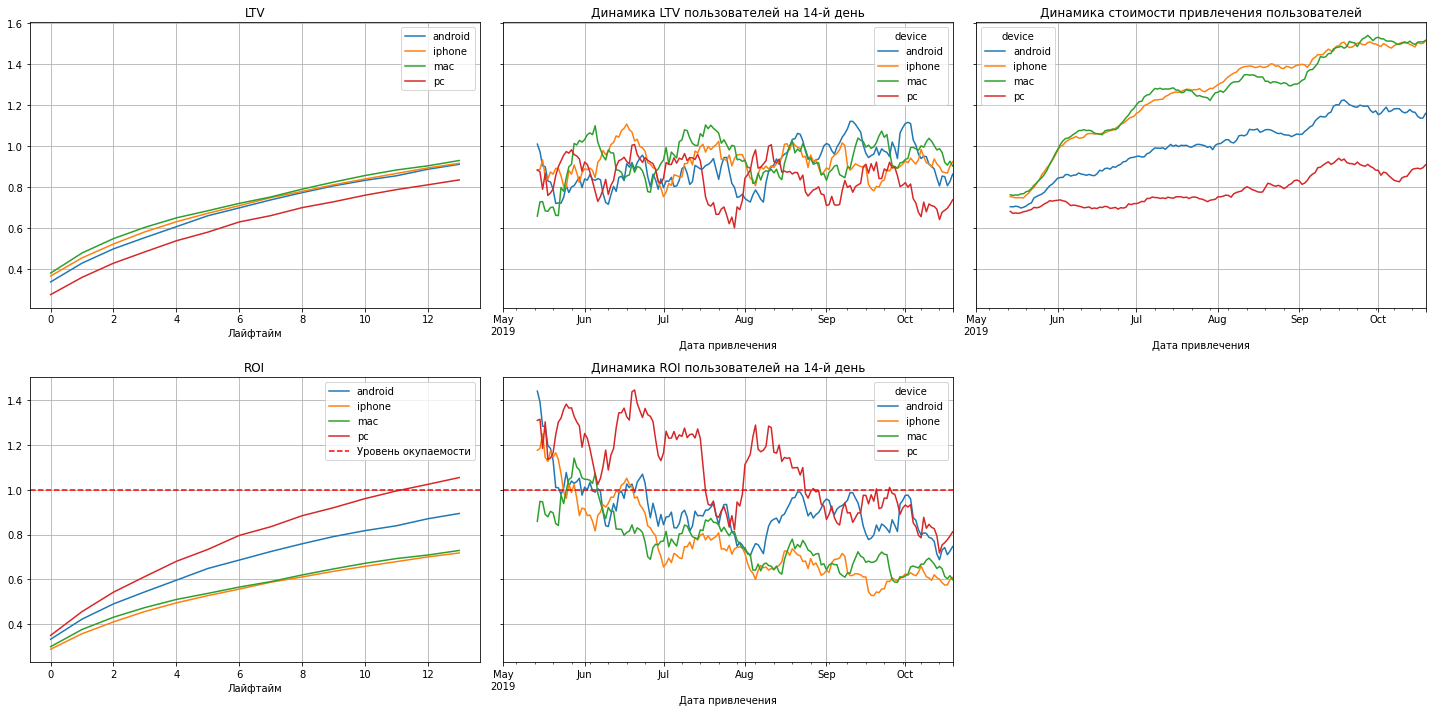

In [60]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<b> Выводы по построенным графикам:</b>

- Пользователи PC окупаются на 11 день, а остальные не окупаются к 14 дню; 

- В динамике ROI видно, что пользователи Android, iPhone окупались до середины июня, PC - до конца августа. Mac - стабильно не окупался;

- Затраты на привлечение у iPhone и Mac почти равны и выше остальных, а ROI хуже. В то время как с PC - наоборот: расходы наименьшие, а ROI лучше, чем у других.

Узнаем, в чём причина: в низкой конверсии или низком удержании.


Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion().

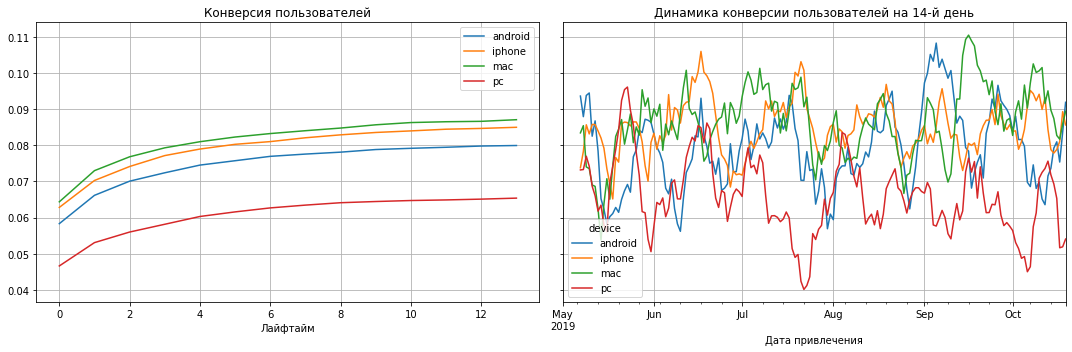

In [61]:
dimensions = ['device']
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи конвертируются хорошо, причём постоянно. 

Видимо, дело в удержании. 

Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

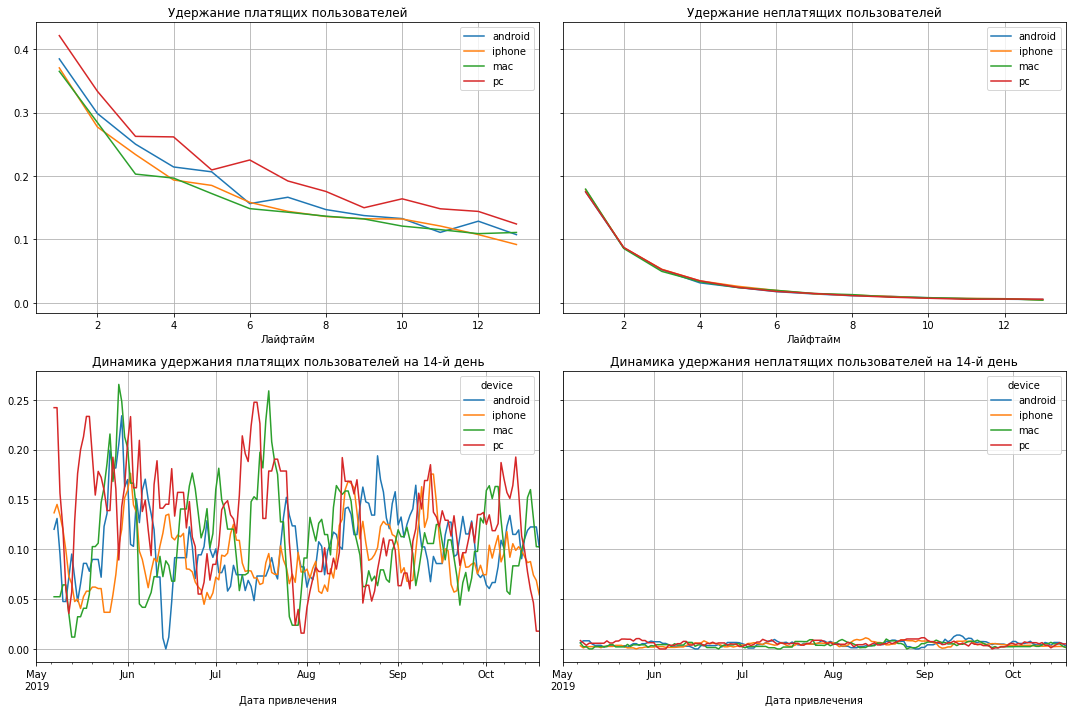

In [62]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Нет каких-то определенных устройств из-за которых пользователи плохо удерживались. 

Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC.

### Проанализируем окупаемость рекламы с разбивкой по странам

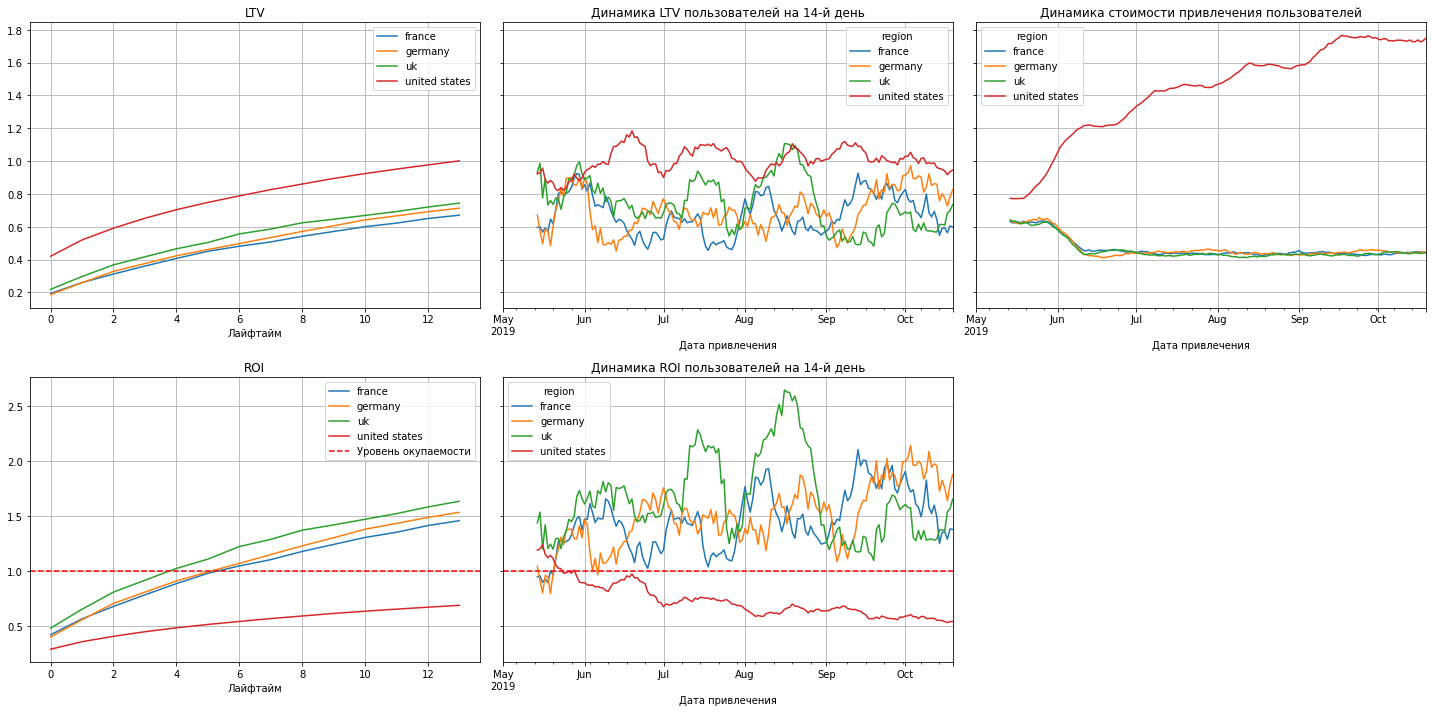

In [63]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<b> Выводы по построенным графикам:</b>
- Реклама окупается не везде. В США уровень окупаемости рекламы низкий, хотя у нас основная аудитория - это пользователи из США.
- При этом стоимость привлечения пользователей из Америки - самая высокая. И она растет.
- LTV всё так же подвержен сезонности, но стабилен.
- Лучше всего окупается Англия и Германия. Явный аутсайдер - США. Причем окупаемость пользователей начала падать с конца мая.

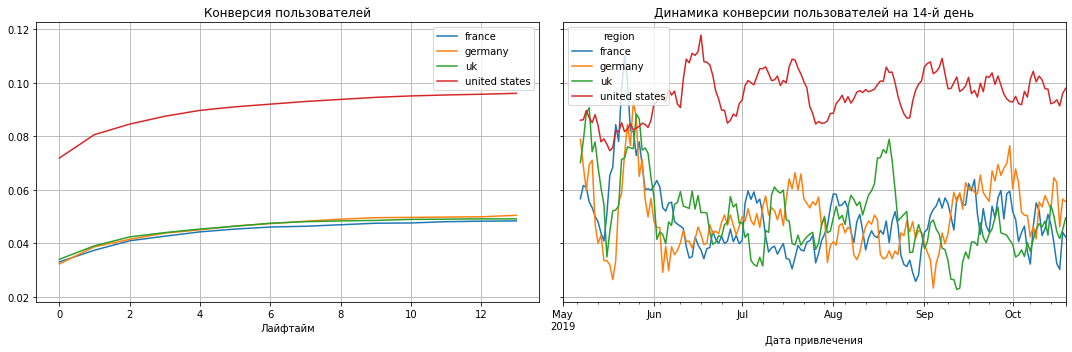

In [64]:
dimensions = ['region']
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

США - лидер в конверсии. Конверсия пользователей Германии, Англии и Франции соответствует доле пользователей.

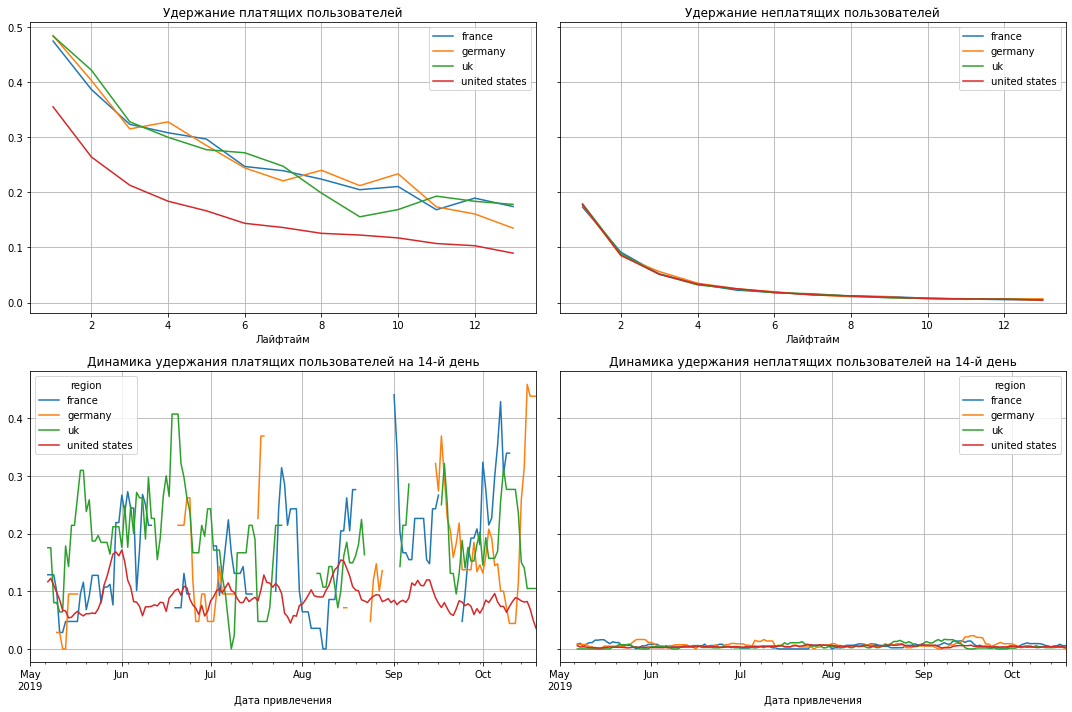

In [65]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи США удерживаются "так-себе".

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

Теперь проверим источники привлечения (channel). Возможно, на окупаемость влияет неудачная реклама в каком-нибудь одном канале.

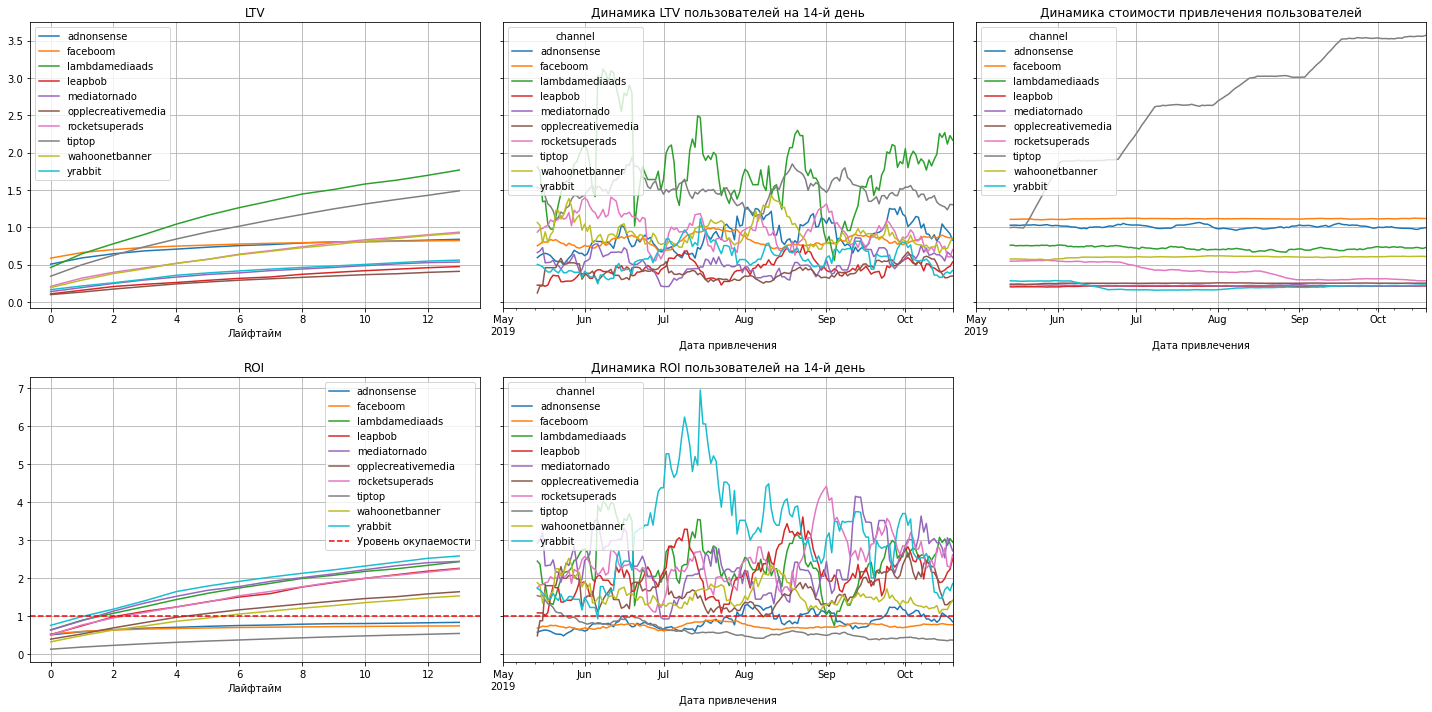

In [66]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

<b> Выводы по построенным графикам:</b>
- Наблюдается рост стоимости привлечения пользователей из рекламного канала tiptop;
- Не окупаются пользователи, привлеченные из каналов adnonsense, faceboom, tiptop.
- ROI yrabbit выделился среди остальных в положительном ключе.

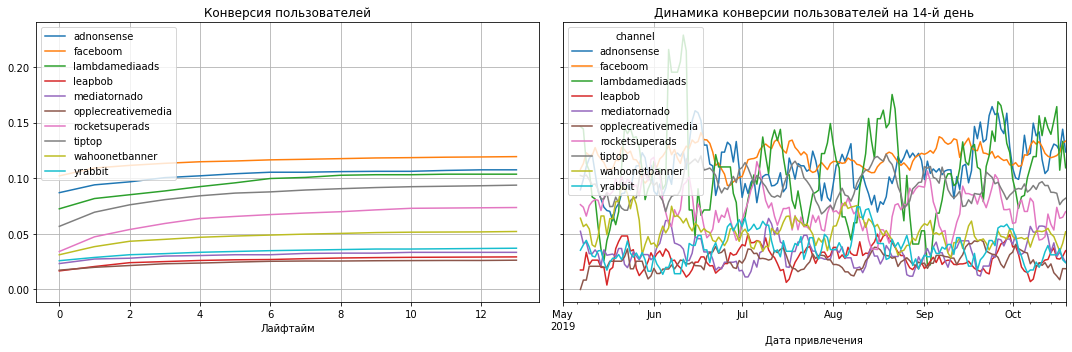

In [67]:
dimensions = ['channel']
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи из opplecreativemedia, leapbob, mediatornado, yrabbit плохо конвертируются.



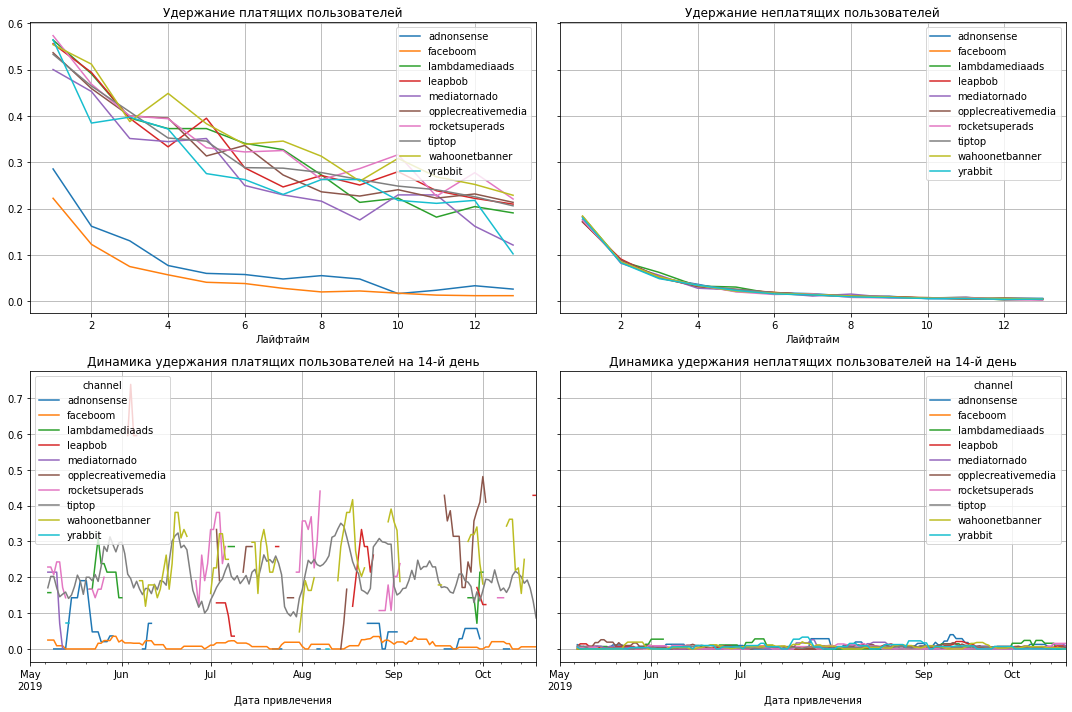

In [68]:
dimensions = ['channel']
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Плохо удерживаются пользователи из каналов faceboom и adnonsense.

<b> Вывод:</b>
- реклама окупается на 80%;
- пользователи, использующие iPhone и Maс, а также пользователи из США снижают окупаемость рекламы;
- пользователи из США также не окупаюся, хотя их 2/3 от всех пользователей в приложении, возможно лучше сосредоточиться на рекламе в других странах (Франция, Германия, Англия), которые окупаются уже на 4-5 день;
- проблемы окупаемости заключаются в неоднородном распределении расходов на рекламу (в tiptop вложили более 50% бюджета, но "выхлопа" от этого не получили);
- не окупаются пользователи, привлеченные из каналов adnonsense, faceboom, tiptop;
- пользователи из opplecreativemedia, leapbob, mediatornado, yrabbit плохо конвертируются;
- плохо удерживаются платящие пользователи из каналов faceboom и adnonsense, а неплатящие, в свою очередь, уоерживаются на всех каналах одинаково плохо.

# Шаг 6. Напишем выводы

<b>Выделим причины неэффективности привлечения пользователей:</b>

- Реклама не окупается к 14 дню. ROI составляет - 80%.

- Нестабильный САС, расходы на привлечение растут с течением времени;

- На LTV влияет сезонный фактор, но в целом, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

- ROI пользователей неумолимо падает. До середины июня показатель был выше уровня окупаемости, но после стал падать.

Чтобы разобраться в причинах, мы прошлись по всем доступным характеристикам пользователей — стране, каналу и устройству первого посещения.

1) Разбивка по устройствам

- В динамике ROI видно, что пользователи Android, iPhone окупались до середины июня, PC - до конца августа. Mac - стабильно не окупался;

- LTV пользователей всё так же подвержен сезонности, но стабилен. Стоимость привлечения пользователей PC самая низкая, а ROI - наоборот, выше остальных. В целом, видим, что стоимость привлечения пользователей всех устройств росла за рассматриваемый период;

- Направить внимание следует на владельцев Mac и iPhone - стоимость их привлечения высока (и растет от месяца к месяцу), а окупаемоcть страдает; 

- Судя по графикам, пользователи Mac, Android и iPhone конвертируются неплохо, причём постоянно. Видимо, дело в удержании. Не видно, чтобы пользователи каких-то определенных устройств особо плохо удерживались. Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC, хуже - владельцы iPhone и Mac.

2) Разбивка по странам

- Реклама окупается не везде. В США уровень окупаемости рекламы низкий, хотя у нас основная аудитория - это пользователи из США. При этом стоимость привлечения пользователей из Америки - самая высокая. И она растет;

- LTV всё так же подвержен сезонности, но стабилен;

- Лучше всего окупается Англия и Германия. Явный аутсайдер - США. Причем окупаемость пользователей начала падать с конца мая;

- Плох удерживаются пользователи из США.

3) Разбивка по каналам привлечения:

- Наблюдается рост стоимости привлечения пользователей из рекламного канала tiptop;

- Не окупаются пользователи, привлеченные из каналов adnonsense, faceboom, tiptop;

- ROI yrabbit выделился среди остальных в положительном ключе;

- Плохо удерживаются пользователи из каналов faceboom и adnonsense.

<b>Сформируем рекомендации для отдела маркетинга для повышения эффективности:</b>

- Пользователи из США имеют низкий уровень окупаемости рекламы, хотя у нас основная аудитория - это пользователи из США (2/3 всех пользователей). При этом стоимость привлечения пользователей из Америки - самая высокая. Необходимо скорректировать распределение расходов по странам. Лучше всего окупается Англия и Германия. Возможно, стоит попробовать закупить больше трафика, целясь на эту аудиторию.

- Сфокусировать внимание на окупаемость владельцев Mac и iPhone - стоимость их привлечения высока, а окупаемоcть страдает. Возможно, стоит сделать маркетинговое предложение именно для владельцев этих устройств.

- Наблюдается рост стоимости привлечения пользователей из рекламного канала tiptop. Позитивного резульата от закупки рекламы в этом канале не было получено. Стоит уменьшить бюджет, выделяемый на эту сеть, и перенаправить на более эффективный канал . 

- Не окупаются пользватели, привлеченные из каналов leapbop, faceboom, tiptop. Больше всего трафика закупали у tiptop, faceboom. Остальные каналы привлечения обходятся довольно дешево. Плохо удерживаются пользователи из каналов faceboom и adnonsense. Можно попробовать переключить внимание на более дешевые, но прибыльные каналы (н-р: lambdamediaads, yrabbit).

- также стоит обратить внимание на пользователей, пришедших из adnonsence и faceboom - почему платящие пользователи имеют резкий отрыв на старте и в течении двухнедельного периода; привлечение их выше среднего, конвертируются они хорошо, но удерживаются плохо (рекомендуется отследить их поведение после оплаты).